# This notebook demonstrates basic examples of fitting, analyzing the results of a fit, and plotting the data.

In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

import lmfit
import matplotlib.pyplot as plt
import numpy as np

from resonator import background, reflection, see

First, we make some fake data to use for the fit. 

In [2]:
# Background parameters
background_model = background.MagnitudePhase()
magnitude = 0.01
phase = -np.pi / 3

# Foreground parameters
foreground_model = reflection.LinearReflection()
f_r = 1e9  # resonance frequency
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000

# Create an array of measurement frequencies
df = 2e6  # frequency width
frequency = np.linspace(f_r - df / 2, f_r + df / 2, 501)

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=frequency, magnitude=magnitude, phase=phase)
fg = foreground_model.func(frequency=frequency, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss)

# The ideal data is the product of the background and foreground, and we add some noise to this.
data = bg * fg + 0.05 * magnitude * (np.random.randn(frequency.size) + 1j * np.random.randn(frequency.size)) 

Fit the data in one line by creating a ResonatorFitter object. This object uses the frequency and data to produce guesses for the inital parameters that will usually be close enough for the fit to converge. In this case, we use the LinearReflectionFitter, assuming that the input power is low enough that the shape of the resonance is not distorted.

In [3]:
r = reflection.LinearReflectionFitter(frequency=frequency, data=data)

Here, `result` is a `lmfit.model.ModelResult` object that contains all of the results of the fit. It's a good idea to look at these fit reports to see the estimates of the standard errors and the correlations between variables. Occasionally, the fit will fail to estimate the errors, and they will all be None.

The five model parameters (variables) are `magnitude` and `phase`, which are parameters of the background model, and `resonance_frequency`, `internal_loss`, and `coupling_loss`, which are parameters of the resonator model. The coupling and internal losses are respectively defined $\Lambda_c \equiv Q_c^{-1}$ and $\Lambda_i \equiv Q_i^{-1}$, where $Q_c$ is the coupling quality factor and $Q_i$ is the internal quality factor. (See `README.md` for an explanation of why the models use these parameters.)

In [4]:
print(r.result.fit_report())

[[Model]]
    (Model(magnitude_phase) * Model(linear_reflection))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1002
    # variables        = 5
    chi-square         = 2.4120e-04
    reduced chi-square = 2.4193e-07
    Akaike info crit   = -15260.1099
    Bayesian info crit = -15235.5611
[[Variables]]
    magnitude:            0.00996387 +/- 2.3045e-05 (0.23%) (init = 0.01081179)
    phase:               -1.04966013 +/- 0.00230885 (0.22%) (init = -1.054909)
    resonance_frequency:  1.0000e+09 +/- 275.682787 (0.00%) (init = 1.000004e+09)
    internal_loss:        1.0014e-05 +/- 5.4420e-07 (5.43%) (init = 2.857802e-05)
    coupling_loss:        5.0146e-05 +/- 4.4114e-07 (0.88%) (init = 5.542164e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(magnitude, internal_loss)     =  0.258
    C(phase, resonance_frequency)   = -0.252
    C(internal_loss, coupling_loss) =  0.175



The ResonatorFitter object makes all of the fit parameters and their estimated standard errors available for attribute access. Since quality factors and energy decay rates are often used instead of the inverse quality factors, the former are available too. See `base.ResonatorFitter` or use `print(dir(r))` to see all of the available quantities.

In [5]:
print("The internal quality factor is Q_i = {:.0f}".format(r.Q_i))
print("The total quality factor is Q_t = {:.0f}".format(r.Q_t))
print("The standard error of the resonance frequency is: {:.0f} Hz".format(r.f_r_error))
print("The total energy decay rate is 2 pi f_r / Q_t = {:.0f} s^-1".format(r.total_energy_decay_rate_error))

The internal quality factor is Q_i = 99862
The total quality factor is Q_t = 16622
The standard error of the resonance frequency is: 276 Hz
The total energy decay rate is 2 pi f_r / Q_t = 4402 s^-1


Check that the fit parameters are mostly within one or two estimated standard errors.

In [6]:
print("Normalized deviations: |fit_value - true_value| / fit_standard_error")
print("f_r: {:.2f}".format(abs(r.f_r - f_r) / r.f_r_error))
print("Q_c: {:.2f}".format(abs(r.Q_c - 1 / coupling_loss) / r.Q_c_error))
print("Q_i: {:.2f}".format(abs(r.Q_i - 1 / internal_loss) / r.Q_i_error))
print("magnitude: {:.2f}".format(abs(r.magnitude - magnitude) / r.magnitude_error))
print("phase: {:.2f}".format(abs(r.phase - phase) / r.phase_error))

Normalized deviations: |fit_value - true_value| / fit_standard_error
f_r: 0.36
Q_c: 0.33
Q_i: 0.03
magnitude: 1.57
phase: 1.07


The `see.py` module contains functions that create nice plots of the data. The `triptych` function shown here plots the same data three different ways.

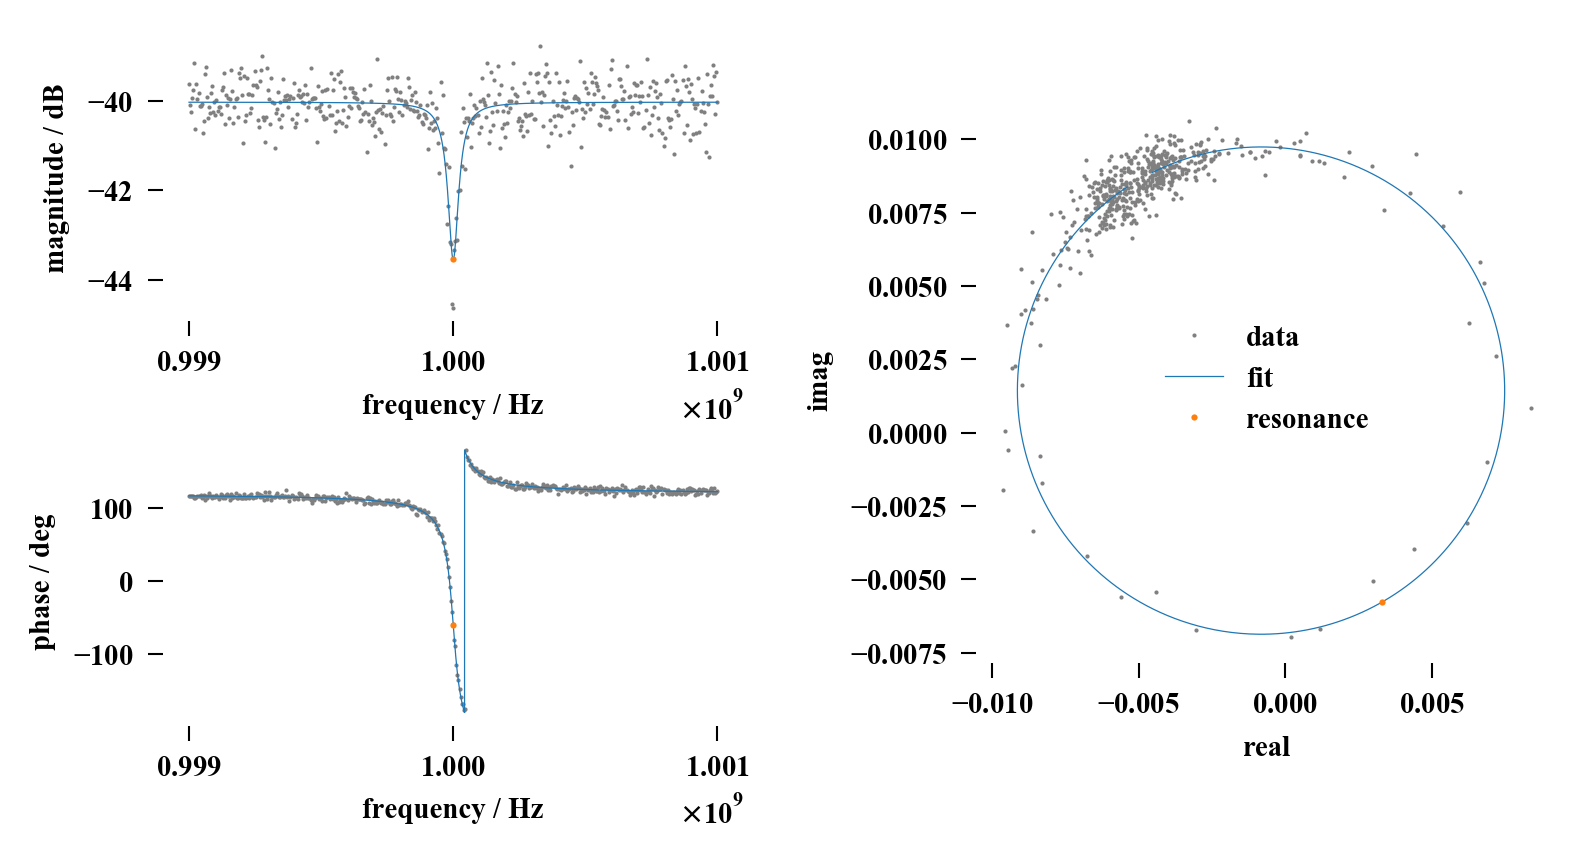

In [7]:
fig, (ax_magnitude, ax_phase, ax_complex) = see.triptych(resonator=r, figure_settings={'figsize': (6, 3), 'dpi': 300})  # Adjust these for your matplotlib settings, 
ax_complex.legend();